In [1]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [3]:
# Reading the saved data pickle file
df_stocks = pd.read_pickle('Data/Pickled ten year filtered data (Articles + DJIA).pkl')

In [16]:
df_stocks.head()

,prices,articles
2007-01-01,12469,What Sticks from '06. Somalia Orders Islamist...
2007-01-02,12472,Heart Health: Vitamin Does Not Prevent Death ...
2007-01-03,12474,Google Answer to Filling Jobs Is an Algorithm...
2007-01-04,12480,Helping Make the Shift From Combat to Commerc...
2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...


In [5]:
df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)

In [6]:
# selecting the prices and articles
df_stocks = df_stocks[['prices', 'articles']]

In [7]:
df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))

/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
df_stocks.head()

,prices,articles
2007-01-01,12469,What Sticks from '06. Somalia Orders Islamist...
2007-01-02,12472,Heart Health: Vitamin Does Not Prevent Death ...
2007-01-03,12474,Google Answer to Filling Jobs Is an Algorithm...
2007-01-04,12480,Helping Make the Shift From Combat to Commerc...
2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...


In [15]:
df = df_stocks[['prices']].copy()
df.head()

,prices
2007-01-01,12469
2007-01-02,12472
2007-01-03,12474
2007-01-04,12480
2007-01-05,12398


In [11]:
# Adding new columns to the data frame
df["compound"] = ''
df["neg"] = ''
df["neu"] = ''
df["pos"] = ''

In [13]:
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,,,,
2007-01-02,12472,,,,
2007-01-03,12474,,,,
2007-01-04,12480,,,,
2007-01-05,12398,,,,


In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sid = SentimentIntensityAnalyzer()
for date, row in df_stocks.T.iteritems():
    try:
        sentence = unicodedata.normalize('NFKD', df_stocks.loc[date, 'articles']).encode('ascii','ignore')
        ss = sid.polarity_scores(sentence)
        df.set_value(date, 'compound', ss['compound'])
        df.set_value(date, 'neg', ss['neg'])
        df.set_value(date, 'neu', ss['neu'])
        df.set_value(date, 'pos', ss['pos'])
    except TypeError:
        print df_stocks.loc[date, 'articles']
        print date

In [327]:
# sentence = 'paris shootout police officer suspected guman dead'
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import unicodedata
# sid = SentimentIntensityAnalyzer()
# ss = sid.polarity_scores(sentence)
# ss

In [163]:
# Checking date for empty strings
# for date, row in df_stocks.T.iteritems():
#     if type(df_stocks.loc[date, 'articles']).__name__ == 'str':
#         print date

In [18]:
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,-0.9735,0.153,0.748,0.099
2007-01-02,12472,-0.9664,0.122,0.784,0.095
2007-01-03,12474,-0.9994,0.207,0.733,0.060
2007-01-04,12480,-0.9982,0.131,0.806,0.062
2007-01-05,12398,-0.9901,0.124,0.794,0.082


In [21]:
train_start_date = '2007-01-01'
train_end_date = '2014-12-31'
test_start_date = '2015-01-01'
test_end_date = '2016-12-31'
train = df.ix[train_start_date : train_end_date]
test = df.ix[test_start_date:test_end_date]

In [22]:
sentiment_score_list = []
for date, row in train.T.iteritems():
    #sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
    sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_train = np.asarray(sentiment_score_list)

In [30]:
sentiment_score_list = []
for date, row in test.T.iteritems():
    #sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
    sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_test = np.asarray(sentiment_score_list)

In [31]:
y_train = pd.DataFrame(train['prices'])
y_test = pd.DataFrame(test['prices'])

In [43]:
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix

rf = RandomForestRegressor(n_estimators=100,n_jobs=-1)
rf.fit(numpy_df_train, y_train)

/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [44]:
print rf.feature_importances_

[ 0.54855674  0.45144326]


In [45]:
prediction, bias, contributions = ti.predict(rf, numpy_df_test)

In [46]:
prediction

array([ 13428.89666667,  12548.87128571,  14227.41916667,  13124.62      ,
        10901.75916667,  13431.87      ,   9580.98333333,  13967.21      ,
        12373.18833333,  13965.89      ,  14362.79      ,  11506.2927381 ,
        12261.26333333,  13293.43247619,  11543.73      ,  13435.40483333,
        11361.76      ,  12342.64690476,  13210.621     ,  11383.85466667,
        11875.42414286,  13320.935     ,  12276.4075    ,  12146.58      ,
        14743.1225    ,  12481.126     ,  11605.36      ,  13133.561     ,
        11060.0695    ,  12802.15      ,  10175.3       ,  14140.04133333,
        12196.04      ,  12473.08633333,  11999.4855    ,  13423.3       ,
        13766.8525    ,  12646.32      ,  13269.25533333,  13314.717     ,
        11567.61983333,  11689.7145    ,  14505.33      ,  12348.005     ,
        13422.83      ,  13097.5       ,  12739.91916667,  12850.34      ,
        13513.9315    ,  12632.5212619 ,  14103.45566667,  12456.9225    ,
        10353.49      ,  

In [47]:
contributions

array([[  713.62635586,   134.52107399],
       [ -187.0530783 ,   155.17512719],
       [ 1341.54631183,   305.12361801],
       ..., 
       [  926.86501604,   170.43874714],
       [ 1885.85010181,  1144.45332803],
       [  131.2384756 , -1315.64771243]])

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
idx = pd.date_range(test_start_date, test_end_date)
predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])

In [50]:
predictions_df.head()

,prices
2015-01-01,13428.896667
2015-01-02,12548.871286
2015-01-03,14227.419167
2015-01-04,13124.620000
2015-01-05,10901.759167


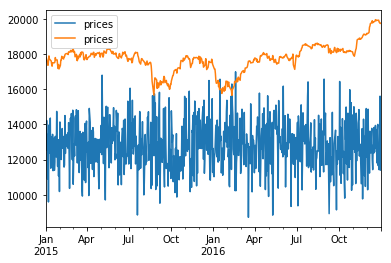

In [51]:
#predictions_df.plot() 
#test['prices'].plot()

predictions_plot = predictions_df.plot()

fig = y_test.plot(ax = predictions_plot).get_figure()

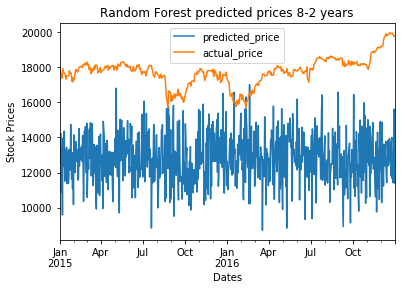

In [53]:
ax = predictions_df.rename(columns={"prices": "predicted_price"}).plot(title='Random Forest predicted prices 8-2 years')
ax.set_xlabel("Dates")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax = ax).get_figure()
#fig.savefig("graphs/random forest without smoothing.png")

# colors = ['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499']

In [54]:
test.head()

,prices,compound,neg,neu,pos
2015-01-01,17828,-0.9484,0.142,0.736,0.121
2015-01-02,17832,-0.9775,0.149,0.759,0.093
2015-01-03,17722,-0.9737,0.131,0.787,0.083
2015-01-04,17612,-0.9971,0.220,0.716,0.064
2015-01-05,17501,-0.9905,0.156,0.767,0.077


# Increasing the prices by a constant value so that it represents closing price during the testing

In [55]:
from datetime import datetime, timedelta

temp_date = test_start_date
average_last_5_days_test = 0
total_days = 10
for i in range(total_days):
    average_last_5_days_test += test.loc[temp_date, 'prices']
    # Converting string to date time
    temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
    # Reducing one day from date time
    difference = temp_date + timedelta(days=1)
    # Converting again date time to string
    temp_date = difference.strftime('%Y-%m-%d')
    #print temp_date
average_last_5_days_test = average_last_5_days_test / total_days
print average_last_5_days_test

temp_date = test_start_date
average_upcoming_5_days_predicted = 0
for i in range(total_days):
    average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
    # Converting string to date time
    temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
    # Adding one day from date time
    difference = temp_date + timedelta(days=1)
    # Converting again date time to string
    temp_date = difference.strftime('%Y-%m-%d')
    print temp_date
average_upcoming_5_days_predicted = average_upcoming_5_days_predicted / total_days
print average_upcoming_5_days_predicted
#average train.loc['2013-12-31', 'prices'] - advpredictions_df.loc['2014-01-01', 'prices']
difference_test_predicted_prices = average_last_5_days_test - average_upcoming_5_days_predicted
print difference_test_predicted_prices

17679.9
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
12755.0707952
4924.82920476


In [56]:
predictions_df.head()

,prices
2015-01-01,13428.896667
2015-01-02,12548.871286
2015-01-03,14227.419167
2015-01-04,13124.620000
2015-01-05,10901.759167


In [57]:
# Adding 6177 to all the advpredictions_df price values
predictions_df['prices'] = predictions_df['prices'] + difference_test_predicted_prices
predictions_df.head()

,prices
2015-01-01,18353.725871
2015-01-02,17473.700490
2015-01-03,19152.248371
2015-01-04,18049.449205
2015-01-05,15826.588371


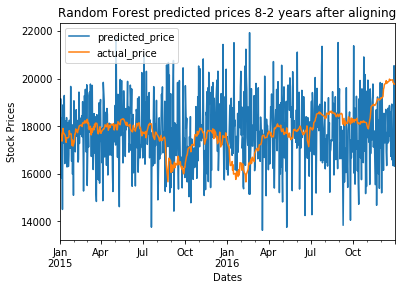

In [59]:
ax = predictions_df.rename(columns={"prices": "predicted_price"}).plot(title='Random Forest predicted prices 8-2 years after aligning')
ax.set_xlabel("Dates")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax = ax).get_figure()
# fig.savefig("graphs/random forest with aligning.png")



# Smoothing the time series data

# Applying EWMA pandas to smooth the stock prices

In [60]:
predictions_df.head()

,prices
2015-01-01,18353.725871
2015-01-02,17473.700490
2015-01-03,19152.248371
2015-01-04,18049.449205
2015-01-05,15826.588371


In [61]:
predictions_df['ewma'] = pd.ewma(predictions_df["prices"], span=60, freq="D")

/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=60,min_periods=0,adjust=True,freq=D).mean()
  """Entry point for launching an IPython kernel.


In [62]:
predictions_df.head()

,prices,ewma
2015-01-01,18353.725871,18353.725871
2015-01-02,17473.700490,17906.379636
2015-01-03,19152.248371,18335.587817
2015-01-04,18049.449205,18260.437363
2015-01-05,15826.588371,17740.684670


In [63]:
predictions_df['actual_value'] = test['prices']
predictions_df['actual_value_ewma'] = pd.ewma(predictions_df["actual_value"], span=60, freq="D")

/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=60,min_periods=0,adjust=True,freq=D).mean()
  


In [64]:
predictions_df.head()

,prices,ewma,actual_value,actual_value_ewma
2015-01-01,18353.725871,18353.725871,17828,17828.000000
2015-01-02,17473.700490,17906.379636,17832,17830.033333
2015-01-03,19152.248371,18335.587817,17722,17792.815295
2015-01-04,18049.449205,18260.437363,17612,17745.326592
2015-01-05,15826.588371,17740.684670,17501,17693.150223


In [65]:
# Changing column names
predictions_df.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']

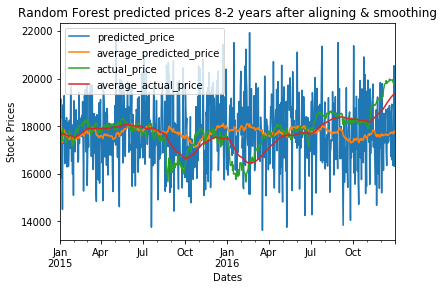

In [66]:
# Now plotting test predictions after smoothing
predictions_plot = predictions_df.plot(title='Random Forest predicted prices 8-2 years after aligning & smoothing')
predictions_plot.set_xlabel("Dates")
predictions_plot.set_ylabel("Stock Prices")
fig = predictions_plot.get_figure()
#fig.savefig("graphs/random forest after smoothing.png")


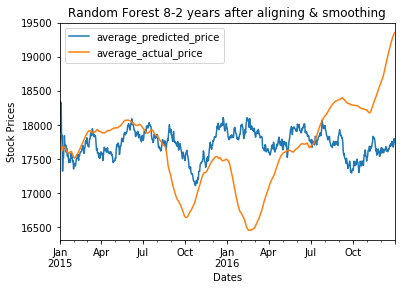

In [67]:
# Plotting just predict and actual average curves
predictions_df_average = predictions_df[['average_predicted_price', 'average_actual_price']]
predictions_plot = predictions_df_average.plot(title='Random Forest 8-2 years after aligning & smoothing')
predictions_plot.set_xlabel("Dates")
predictions_plot.set_ylabel("Stock Prices")
fig = predictions_plot.get_figure()

# Increasing the prices by a constant value so that it represents closing price during the testing

In [68]:
def offset_value(test_start_date, test, predictions_df):
    temp_date = test_start_date
    average_last_5_days_test = 0
    average_upcoming_5_days_predicted = 0
    total_days = 10
    for i in range(total_days):
        average_last_5_days_test += test.loc[temp_date, 'prices']
        temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
        difference = temp_date + timedelta(days=1)
        temp_date = difference.strftime('%Y-%m-%d')
    average_last_5_days_test = average_last_5_days_test / total_days

    temp_date = test_start_date
    for i in range(total_days):
        average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
        temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
        difference = temp_date + timedelta(days=1)
        temp_date = difference.strftime('%Y-%m-%d')
    average_upcoming_5_days_predicted = average_upcoming_5_days_predicted / total_days
    difference_test_predicted_prices = average_last_5_days_test - average_upcoming_5_days_predicted
    return difference_test_predicted_prices

# LogisticRegression

/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:60: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=10,min_periods=0,adjust=True,freq=D).mean()
/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:62: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=10,min_periods=0,adjust=True,freq=D).mean()


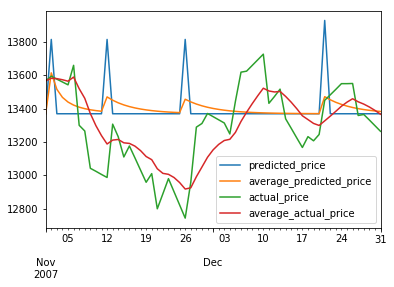

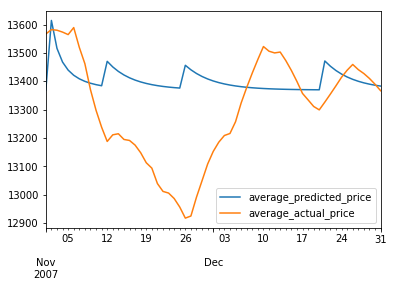

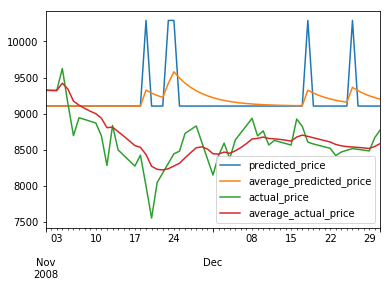

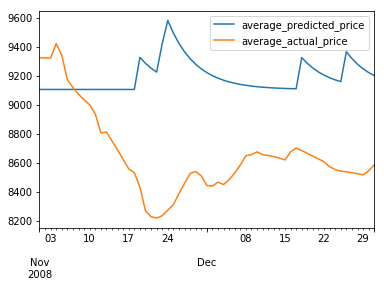

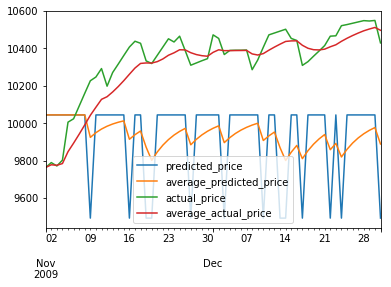

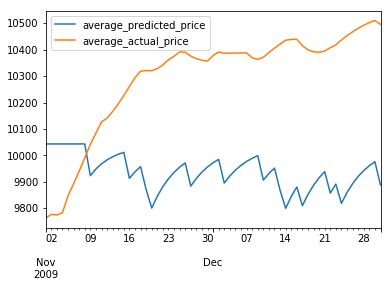

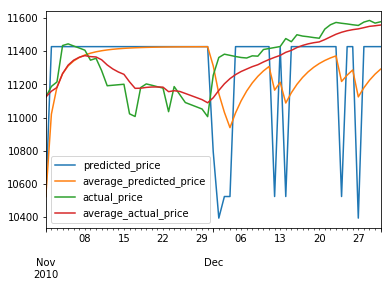

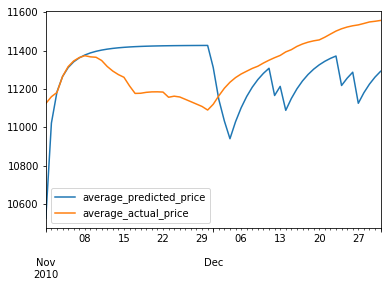

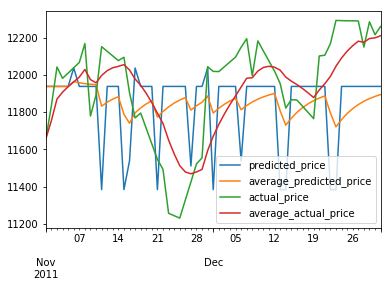

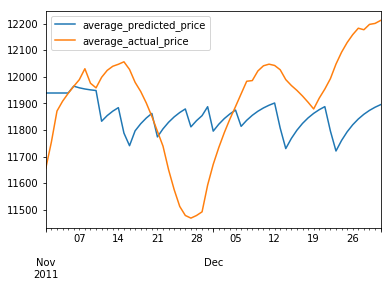

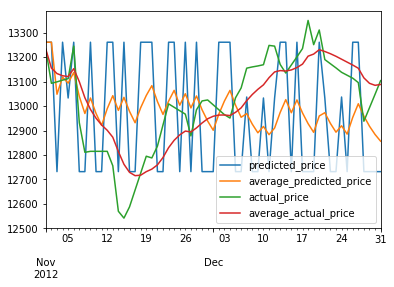

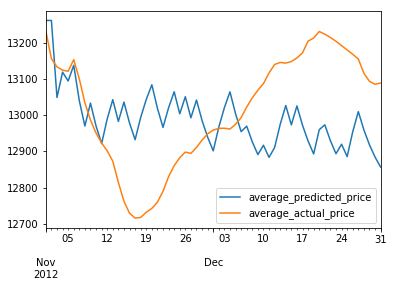

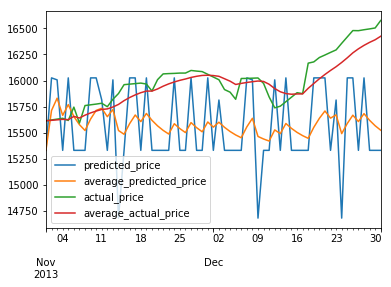

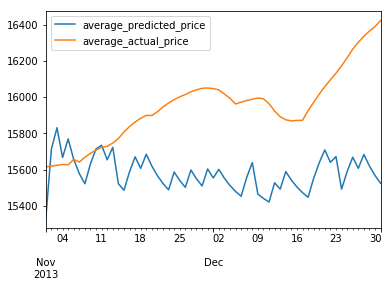

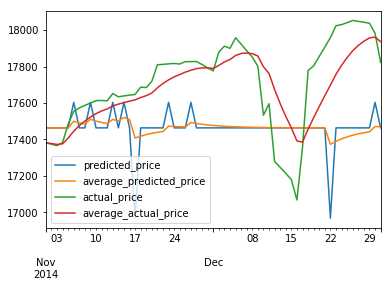

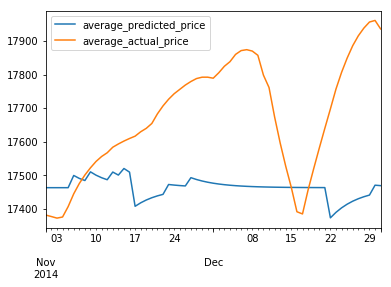

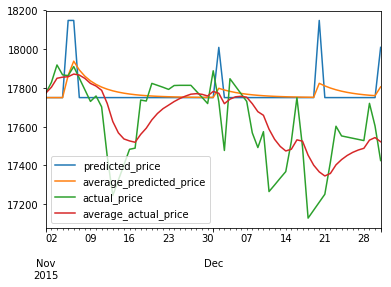

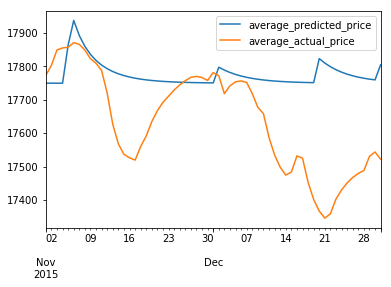

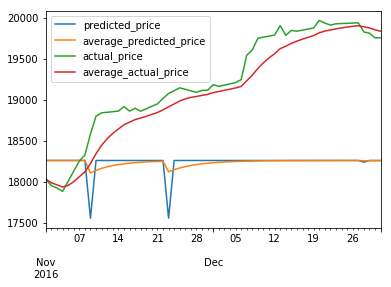

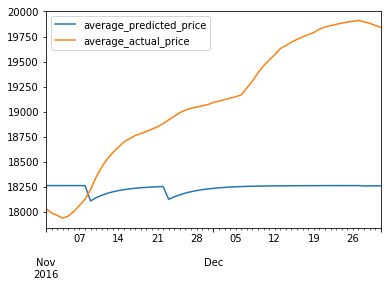

In [69]:
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta

# average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
# # Converting string to date time
# temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
# # Adding one day from date time
# difference = temp_date + timedelta(days=1)
# # Converting again date time to string
# temp_date = difference.strftime('%Y-%m-%d')
        
# start_year = datetime.strptime(train_start_date, "%Y-%m-%d").date().month

years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    # Splitting the training and testing data
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-12-31'
    train = df.ix[train_start_date : train_end_date]
    test = df.ix[test_start_date:test_end_date]
    
    # Calculating the sentiment score
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)
    
    # Generating models
    lr = LogisticRegression()
    lr.fit(numpy_df_train, train['prices'])
    

    prediction = lr.predict(numpy_df_test)
    prediction_list.append(prediction)
    #print train_start_date + ' ' + train_end_date + ' ' + test_start_date + ' ' + test_end_date
    idx = pd.date_range(test_start_date, test_end_date)
    #print year
    predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
    
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = pd.ewma(predictions_df_list["prices"], span=10, freq="D")
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = pd.ewma(predictions_df_list["actual_value"], span=10, freq="D")
    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    predictions_df_list.plot()
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    predictions_df_list_average.plot()
    
#     predictions_df_list.show()
    

In [70]:
lr.classes_

array([15660, 15766, 15882, 15885, 15914, 15944, 15954, 15973, 15988,
       15995, 16002, 16009, 16014, 16016, 16024, 16027, 16029, 16069,
       16085, 16086, 16093, 16140, 16145, 16151, 16153, 16167, 16196,
       16204, 16336, 16346, 16363, 16379, 16381, 16391, 16398, 16413,
       16416, 16431, 16449, 16453, 16454, 16460, 16466, 16468, 16484,
       16514, 16516, 16544, 16557, 16598, 16620, 16639, 16697, 16865,
       16899, 16906, 16943, 16964, 16995, 17000, 17006, 17029, 17051,
       17073, 17140, 17148, 17158, 17213, 17217, 17218, 17223, 17227,
       17229, 17251, 17286, 17313, 17325, 17356, 17400, 17409, 17435,
       17481, 17492, 17495, 17498, 17500, 17502, 17515, 17520, 17525,
       17526, 17529, 17530, 17535, 17541, 17556, 17563, 17570, 17576,
       17582, 17593, 17602, 17603, 17609, 17616, 17623, 17633, 17640,
       17651, 17652, 17660, 17674, 17675, 17685, 17694, 17705, 17706,
       17710, 17711, 17716, 17717, 17718, 17720, 17721, 17729, 17732,
       17733, 17737,

In [71]:
lr.coef_[0]

array([ 0.83199168, -0.31151046, -1.83807249, -0.26895549])

# RandomForestRegressor

/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:60: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=10,min_periods=0,adjust=True,freq=D).mean()
/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:62: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=10,min_periods=0,adjust=True,freq=D).mean()


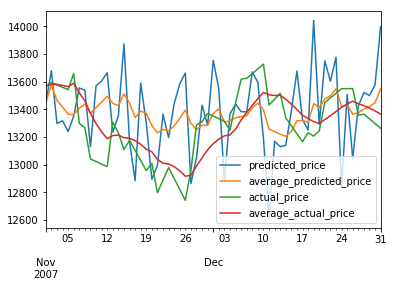

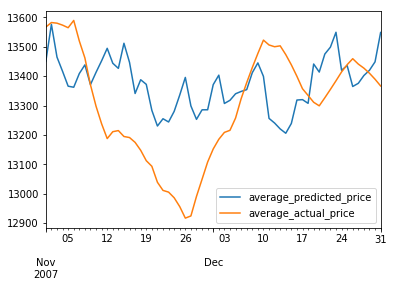

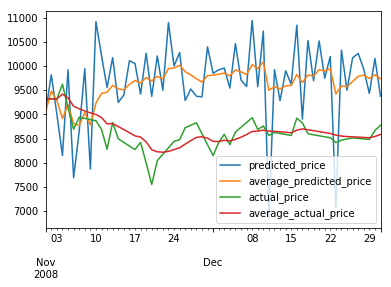

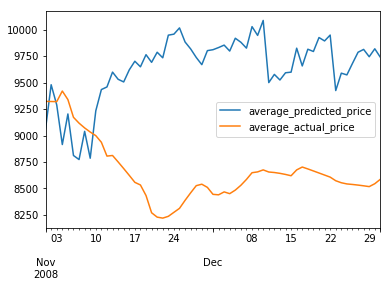

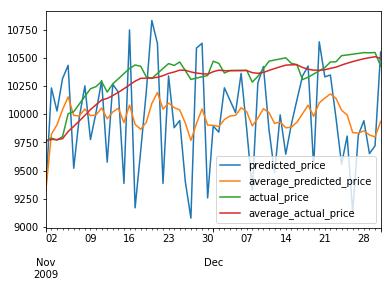

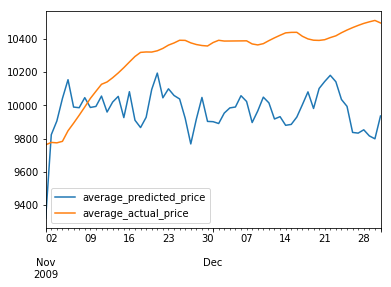

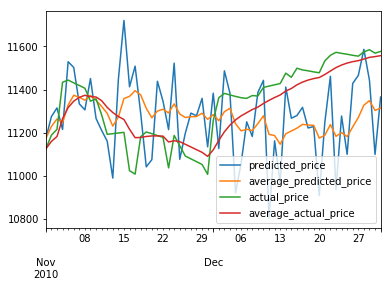

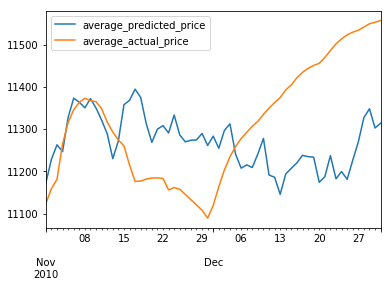

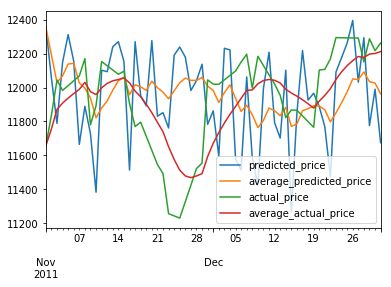

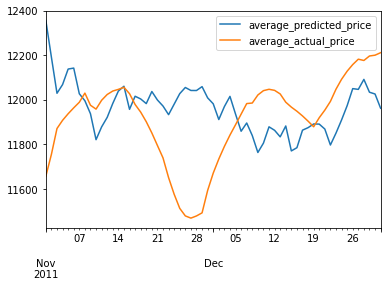

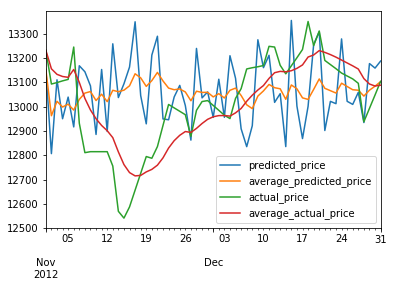

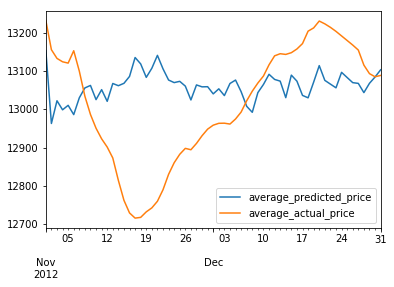

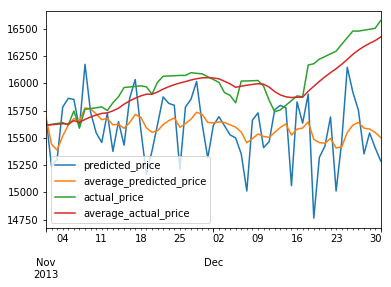

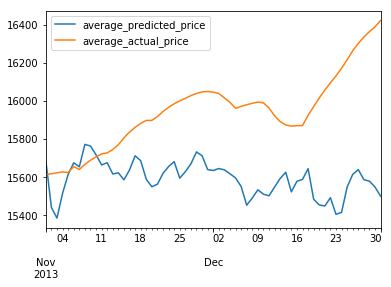

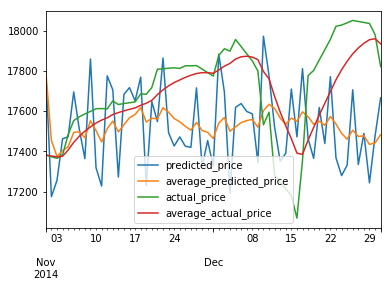

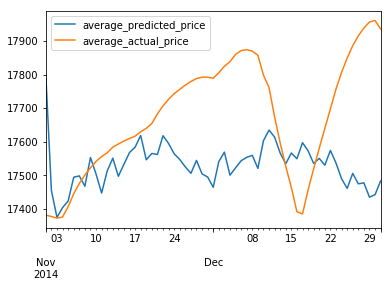

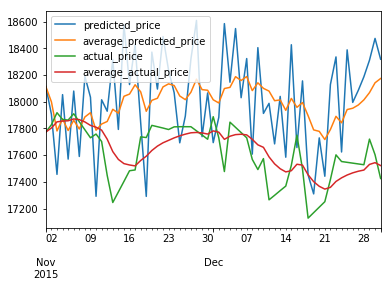

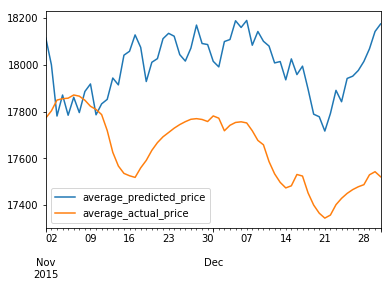

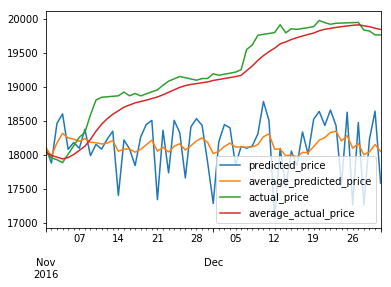

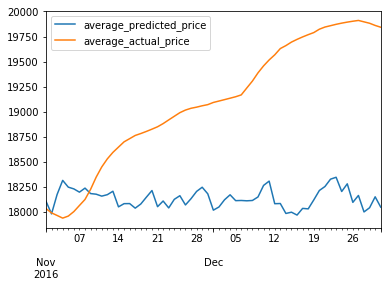

In [79]:
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta

# average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
# # Converting string to date time
# temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
# # Adding one day from date time
# difference = temp_date + timedelta(days=1)
# # Converting again date time to string
# temp_date = difference.strftime('%Y-%m-%d')
        
# start_year = datetime.strptime(train_start_date, "%Y-%m-%d").date().month

years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    # Splitting the training and testing data
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-12-31'
    train = df.ix[train_start_date : train_end_date]
    test = df.ix[test_start_date:test_end_date]
    
    # Calculating the sentiment score
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)
    
    # Generating models
    rf = RandomForestRegressor()
    rf.fit(numpy_df_train, train['prices'])
    #print rf
    
    prediction, bias, contributions = ti.predict(rf, numpy_df_test)
    prediction_list.append(prediction)
    #print train_start_date + ' ' + train_end_date + ' ' + test_start_date + ' ' + test_end_date
    idx = pd.date_range(test_start_date, test_end_date)
    #print year
    predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
    
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = pd.ewma(predictions_df_list["prices"], span=10, freq="D")
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = pd.ewma(predictions_df_list["actual_value"], span=10, freq="D")
    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    predictions_df_list.plot()
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    predictions_df_list_average.plot()
    
#     predictions_df_list.show()
    

In [73]:
# from IPython.display import Image  
# dot_data = tree.export_graphviz(rf, out_file=None, 
#                      feature_names=['comp', 'neg', 'neu', 'pos'],  
#                      class_names=iris.target_names,  
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = pydotplus.graph_from_dot_data(dot_data)  
# Image(graph.create_png())

# MLP Classifier

/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=20,min_periods=0,adjust=True,freq=D).mean()
/home/parth/.local/lib/python2.7/site-packages/ipykernel_launcher.py:59: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=20,min_periods=0,adjust=True,freq=D).mean()


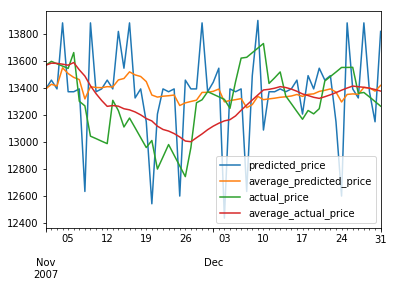

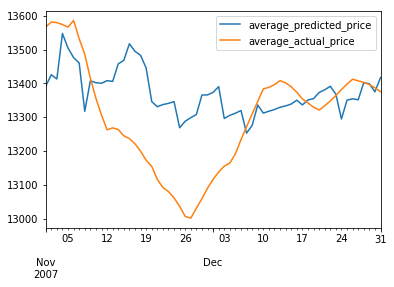

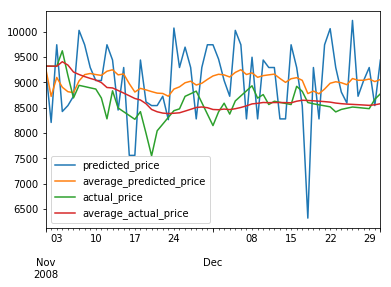

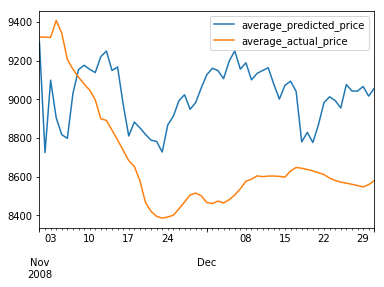

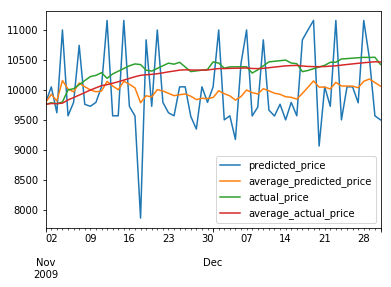

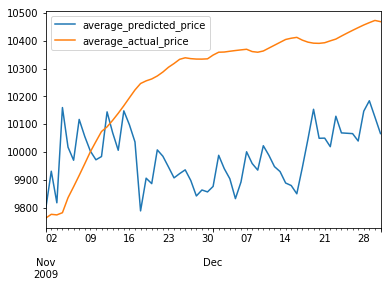

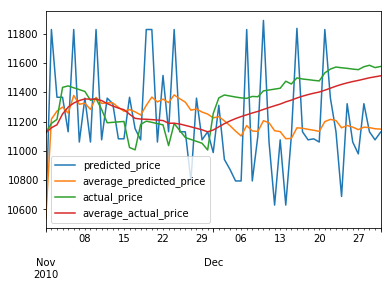

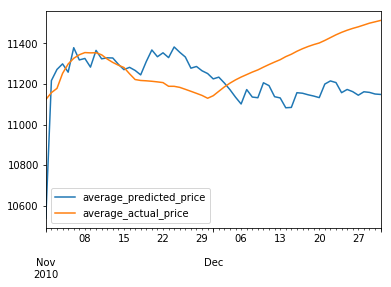

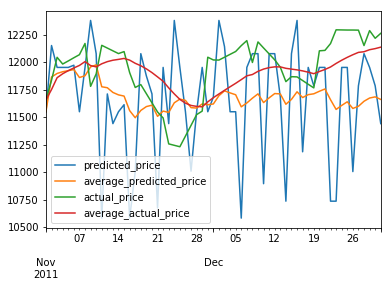

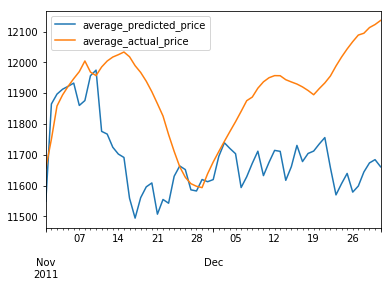

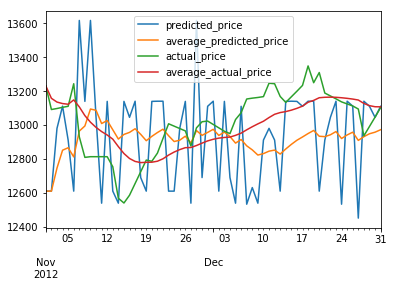

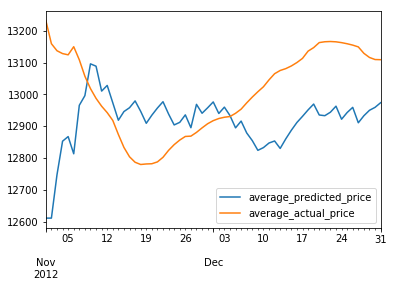

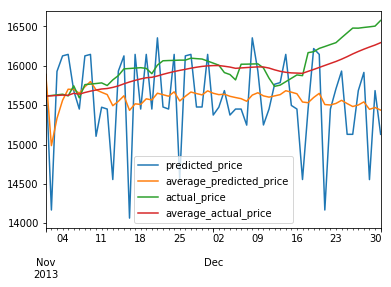

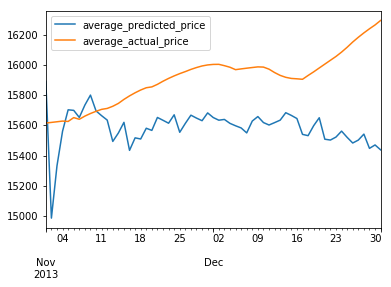

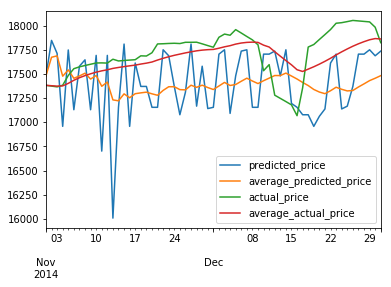

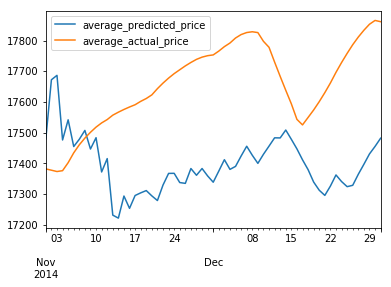

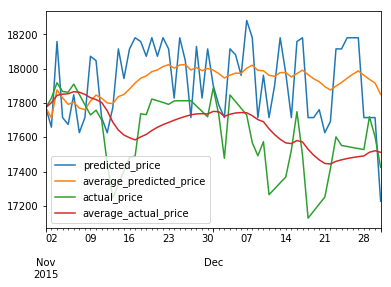

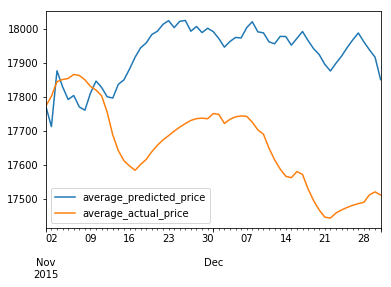

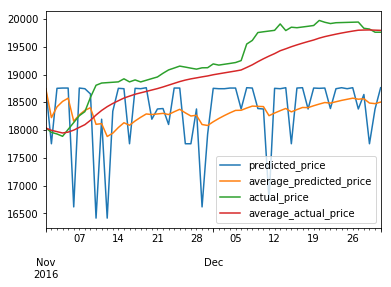

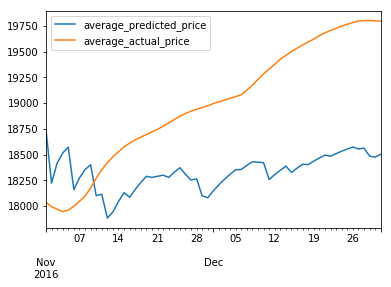

In [74]:
from sklearn.neural_network import MLPClassifier
from datetime import datetime, timedelta

# average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
# # Converting string to date time
# temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
# # Adding one day from date time
# difference = temp_date + timedelta(days=1)
# # Converting again date time to string
# temp_date = difference.strftime('%Y-%m-%d')
        
# start_year = datetime.strptime(train_start_date, "%Y-%m-%d").date().month

years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    # Splitting the training and testing data
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-12-31'
    train = df.ix[train_start_date : train_end_date]
    test = df.ix[test_start_date:test_end_date]
    
    # Calculating the sentiment score
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)
    
    # Generating models
    mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', 
                         solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False) # span = 20 # best 1
    mlpc.fit(numpy_df_train, train['prices'])   
    prediction = mlpc.predict(numpy_df_test)
    
    prediction_list.append(prediction)
    #print train_start_date + ' ' + train_end_date + ' ' + test_start_date + ' ' + test_end_date
    idx = pd.date_range(test_start_date, test_end_date)
    #print year
    predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
    
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = pd.ewma(predictions_df_list["prices"], span=20, freq="D")
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = pd.ewma(predictions_df_list["actual_value"], span=20, freq="D")
    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    predictions_df_list.plot()
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    predictions_df_list_average.plot()
    
#     predictions_df_list.show()
    

In [77]:
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='tanh', 
                         solver='lbfgs', alpha=0.010, learning_rate_init = 0.001, shuffle=False)
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', 
                         solver='lbfgs', alpha=0.010, learning_rate_init = 0.001, shuffle=False) # span = 20
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', 
                         solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False) # span = 20 # best 1
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 50), activation='relu', 
                         solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False)                  